In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
# Preprocessing
import re
from collections import Counter
import string
import emoji
import html
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Dict, List
from scipy.sparse import vstack
from multiprocessing import Pool

In [2]:
directory_main = '/kaggle/input/tweets-500/Tweets'
directory_engg = '/kaggle/input/engineering-tweets-dataset/Output Data [Engineering]/Output Data [Engineering]'
directory_business = '/kaggle/input/tweet-business-schools/Output Data [Business]'
directory_law = '/kaggle/input/tweet-law-schools/Output Data [Law]'
directory_med = '/kaggle/input/tweet-med-schools/Output Data [Med]'

## Preprocess Tweets

In [4]:
# Load stopwords once
STOPWORDS = set(stopwords.words('english'))
# Define a list of unwanted words (like 'rt', 'amp', etc.)
UNWANTED_WORDS = {'rt', 'amp', 'pm', 'w', 'mt', 'gt', 'lt'}

def preprocess_tweets_vectorized(df, text_column='Tweet'):
    """
    Optimized vectorized preprocessing for tweets in a pandas DataFrame.
    Args:
        df (pd.DataFrame): DataFrame containing the tweets.
        text_column (str): Column name containing the tweets.
    Returns:
        pd.Series: Processed tweets as a pandas Series.
    """
    # Step 1: Lowercase the tweets
    df[text_column] = df[text_column].str.lower()

    # Step 2: Remove URLs
    url_pattern = r'https?://\S+|www\.\S+'
    df[text_column] = df[text_column].str.replace(url_pattern, '', regex=True)

    # Step 3: Remove mentions
    mention_pattern = r'@\w+'
    df[text_column] = df[text_column].str.replace(mention_pattern, '', regex=True)

    # Step 4: Remove emojis
    emoji_pattern = (
        r"["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+"
    )
    df[text_column] = df[text_column].str.replace(emoji_pattern, '', regex=True)

    # Step 5: Remove special characters and punctuation
    special_char_pattern = r'[^\w\s]'
    df[text_column] = df[text_column].str.replace(special_char_pattern, '', regex=True)

    # Step 6: Remove extra whitespaces
    df[text_column] = df[text_column].str.replace(r'\s+', ' ', regex=True).str.strip()

    # Step 7: Remove stopwords
    df[text_column] = df[text_column].apply(
        lambda x: ' '.join(word for word in x.split() if word not in STOPWORDS and word not in UNWANTED_WORDS)
    )

    return df[text_column]


In [5]:
def process_csv_in_batches(file_path, chunk_size=10000, text_column='Tweet', processed_column='Processed Tweet'):
    """
    Process a CSV file in batches, applying preprocessing to each batch, and saving the results in a new column.
    
    Args:
        file_path (str): Path to the CSV file.
        chunk_size (int): The number of rows to process at a time.
        text_column (str): Column name containing the tweets.
        processed_column (str): Column name where processed tweets will be stored.
    
    Returns:
        pd.DataFrame: Processed dataframe with tweets.
    """
    # Initialize an empty list to store processed chunks
    processed_chunks = []
    
    # Read CSV file in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Preprocess tweets and store them in the 'Processed Tweet' column
        chunk[processed_column] = preprocess_tweets_vectorized(chunk, text_column)
        # Append the processed chunk to the list
        processed_chunks.append(chunk)
    
    # Concatenate all processed chunks into a single DataFrame
    processed_df = pd.concat(processed_chunks, axis=0, ignore_index=True)
    
    return processed_df

In [6]:
def create_dataset(directory, chunk_size=10000, text_column='Tweet', processed_column='Processed Tweet'):
    """
    Create a dataset from CSV files in a directory, processing each in batches and saving the result in a new column.
    
    Args:
        directory (str): Directory containing the CSV files.
        chunk_size (int): The number of rows to process at a time.
        text_column (str): Column name containing the tweets.
        processed_column (str): Column name where processed tweets will be stored.
    
    Returns:
        pd.DataFrame: Combined DataFrame with processed tweets from all CSV files in the directory.
    """
    # Initialize an empty list to store processed dataframes
    all_df_list = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Process each file in batches and save processed tweets in a new column
        processed_df = process_csv_in_batches(file_path, chunk_size, text_column, processed_column)
        
        # Append the processed dataframe to the list
        all_df_list.append(processed_df)
    
    # Concatenate all processed dataframes into a single DataFrame
    final_df = pd.concat(all_df_list, axis=0, ignore_index=True)
    
    return final_df

In [7]:
tweets_main = create_dataset(directory_main)
tweets_engg = create_dataset(directory_engg)
tweets_business = create_dataset(directory_business)
tweets_law = create_dataset(directory_law)
tweets_med = create_dataset(directory_med)

In [8]:
tweets = pd.concat([tweets_main, tweets_engg, tweets_business, tweets_law, tweets_med], axis = 0, ignore_index = True)

In [ ]:
tweets.columns

In [29]:
# Convert the 'Date' column to datetime and extract the year
dataframes = [tweets, tweets_main, tweets_engg, tweets_business, tweets_law, tweets_med]

for df in dataframes:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Year'] = df['Date'].dt.year


## Tf IDF Analysis

In [10]:
dei_keywords = ['restorative justice', 'african american', 'teenagers', 'economic justice', 'accessibilitypoverty', 'marginalized communities', 'inclusion', 'george floyd', 
 'autism', 'vaccineequity', 'governance', 'female', 'racialized', 'identities', 'first black', 'accessibility', 'representation', 'equity', 'activist', 'patient', 
 'latino', 'native american', 'human rights', 'Indigenous', 'equal access', 'anti-racism', 'representation matters', 'intersectional justice', 
 'resistance', 'affirmative action', 'poverty', 'fair', 'heritage', 'mental health inclusion', 'diversity', 'gender justice', 'intersectionality', 'black lives matter', 
 'transitional', 'equity-driven', 'equitable', 'undocumented', 'cultural competency', 'cultural', 'civil rights', 'minority', 'samesex', 'justice', 
 'disadvantaged', 'lgbtq', 'systemic racism', 'injustice', 'blackhistorymonth', 'multiculturalism', 'equality', 'disability rights', 'asian', 'immigration', 'access', 
 'first woman', 'belonging', 'ethics', 'inequality', 'lowincome', 'rights', 'stereotypes', 'african', 'mandela', 'civil', 'economic equity', 'oppression', 
 'disparities', 'bias', 'gender', 'celebratefirstgen', 'policing', 'racial justice', 'nationality', 'impartial', 'intersectional', 'equality in education', 'civil liberties', 
 'unconscious bias', 'blackexcellence', 'discrimination', 'minorities', 'just', 'veterans', 'microaggressions', 'inequity', 'peace', 'racism', 'social change', 'refugees', 
 'firstgen', 'segregation', 'voting', 'advocacy', 'mental health', 'fairness', 'global', 'inclusive', 'merit', 'barrier', 'vulnerable', 'trans', 'neurodiversity', 'gender expression', 'hbcu', 
 'mental', 'underrepresented', 'stigma', 'multicultural', 'safe space', 'black', 'ally', 'queer', 'privilege', 'systemic', 'blm', 'transgender',
 'disabilities', 'sexuality', 'rural', 'freedom', 'LGBTQ+ rights', 'indigenous', 'inclusive leadership', 'social inequality', 'backgrounds', 'ethnic', 'social justice', 
 'reform', 'hispanic', 'racial', 'gender equality', 'human rights', 'international law', 'refugeeautism', 'allyship', 'immigrants', 'racial equity', 'historicaaging', 
 'protest', 'women', 'health disparity', 'disability inclusion', 'belief', 'marginalized', 'non-binary', 'accountability', 'religious', 'underserved', 'community engagement']

## By Year

In [31]:
def compute_tfidf_for_year(df, year):
    """
    Compute TF-IDF scores for tweets from a specific year.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'Tweets' and 'Year' columns.
    year (int): The year to filter tweets.
    
    Returns:
    pd.DataFrame: DataFrame with columns 'Words' and 'Tfidf Score' sorted in descending order.
    """
    # Filter tweets for the given year
    tweets = df[df['Year'] == year]['Tweet'].dropna().tolist()
    
    # Compute TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(tweets)
    
    # Get feature names and corresponding scores
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    
    # Create DataFrame
    tfidf_df = pd.DataFrame({'Words': feature_names, 'Tfidf Score': scores})
    
    # Sort by TF-IDF score in descending order
    return tfidf_df.sort_values(by='Tfidf Score', ascending=False).reset_index(drop=True)

In [32]:
tfidf_by_year = compute_tfidf_for_year(tweets, 2020)
tfidf_by_year.head()

,Words,Tfidf Score
0,students,8242.299074
1,covid19,5859.126032
2,us,5699.454741
3,congratulations,5473.543171
4,new,5469.425852


In [34]:
top_words = tfidf_by_year['Words'].tolist()[:1001]

In [ ]:
for word in top_words:
    print(word)

## By University Ranking

In [18]:
def calculate_tfidf_by_ranking(data, text_col, rank_col, brackets, top_n=500):
    """
    Groups universities by ranking brackets, calculates TF-IDF scores, and returns top keywords for each bracket.

    Args:
        data (pd.DataFrame): Input dataframe containing text and ranking information.
        text_col (str): Column name containing the text data.
        rank_col (str): Column name containing the university rankings.
        brackets (dict): Dictionary defining ranking brackets with keys as labels and values as (min_rank, max_rank).
        top_n (int): Number of top keywords to extract for each bracket.

    Returns:
        pd.DataFrame: Dataframe with ranking bracket, keywords, and their TF-IDF scores.
    """
    # Convert rank column to integers (handle any non-numeric cases)
    data[rank_col] = pd.to_numeric(data[rank_col], errors='coerce')

    # Drop rows where rank is NaN
    data = data.dropna(subset=[rank_col])
    data[rank_col] = data[rank_col].astype(int)

    # Add a new column for ranking brackets
    def assign_bracket(rank):
        for bracket, (min_rank, max_rank) in brackets.items():
            if min_rank <= rank <= max_rank:
                return bracket
        return None

    data['RankBracket'] = data[rank_col].apply(assign_bracket)

    # Initialize a DataFrame to store results
    tfidf_results = []

    # Calculate TF-IDF for each bracket
    for bracket in brackets.keys():
        bracket_data = data[data['RankBracket'] == bracket]

        # Combine all text for each bracket
        if not bracket_data.empty:
            vectorizer = TfidfVectorizer(lowercase=False, ngram_range = (1, 3), stop_words='english', norm='l2')
            tfidf_matrix = vectorizer.fit_transform(bracket_data[text_col])
            feature_names = vectorizer.get_feature_names_out()
            scores = tfidf_matrix.max(axis=0)  # Sum scores for all documents
            tfidf_scores = pd.DataFrame({'Word': feature_names, 'Score': scores})
            tfidf_scores = tfidf_scores.sort_values(by='Score', ascending=False).head(top_n)

            # Add the bracket information
            tfidf_scores['RankBracket'] = bracket
            tfidf_results.append(tfidf_scores)

    # Combine results from all brackets
    return pd.concat(tfidf_results, ignore_index=True)


In [12]:
# Example Usage
brackets = {
    'Top': (1, 50),
    'Mid': (51, 200),
    'Bottom': (201, 500)
}


In [19]:
# Assuming `df` is your dataframe
result_df = calculate_tfidf_by_ranking(
    data=tweets,
    text_col='Processed Tweet',
    rank_col='USNewsRank',
    brackets=brackets,
    top_n=500
)

# Save or inspect the result
print(result_df)

/tmp/ipykernel_30/2088418496.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[rank_col] = data[rank_col].astype(int)
/tmp/ipykernel_30/2088418496.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RankBracket'] = data[rank_col].apply(assign_bracket)


TypeError: 'coo_matrix' object is not subscriptable

In [14]:
top_dei_words_ranking_df = result_df[result_df['Word'].isin([word.lower() for word in dei_keywords])]

In [15]:
def plot_keywords_by_ranking_bracket(tfidf_df, bracket_col='RankBracket', word_col='Word', score_col='Score', top_n=10, save_path=None):
    """
    Plots top DEI keywords for each ranking bracket side by side with an overall title and specific ranking ranges in subplot titles.

    Args:
        tfidf_df (pd.DataFrame): DataFrame containing TF-IDF scores and brackets.
        bracket_col (str): Column name for the ranking brackets.
        word_col (str): Column name for the keywords.
        score_col (str): Column name for the TF-IDF scores.
        top_n (int): Number of top keywords to display.
        save_path (str): Path to save the plot image. If None, the plot is not saved.
    """
    import matplotlib.pyplot as plt

    # Define ranking ranges for each bracket
    bracket_ranges = {
        'Top': 'Rank 1-50',
        'Mid': 'Rank 51-200',
        'Bottom': 'Rank 201-500'
    }
    
    brackets = tfidf_df[bracket_col].unique()
    fig, axes = plt.subplots(1, len(brackets), figsize=(18, 6), sharey=False)

    for idx, bracket in enumerate(brackets):
        ax = axes[idx]
        bracket_data = tfidf_df[tfidf_df[bracket_col] == bracket].nlargest(top_n, score_col)
        
        # Plot horizontal bar chart
        ax.barh(bracket_data[word_col], bracket_data[score_col], color='skyblue')
        ax.set_title(f"{bracket} Ranking Universities ({bracket_ranges.get(bracket, 'Unknown Range')})", fontsize=12)
        ax.set_xlabel("TF-IDF Score", fontsize=10)
        ax.set_ylabel("Keywords", fontsize=10)
        ax.invert_yaxis()  # Highest score at the top

    # Add overall title
    fig.suptitle("Top DEI Keywords by University Ranking", fontsize=16, y=1.02)

    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    # Show the plot
    plt.show()


Plot saved to /kaggle/working/top_dei_keywords_by_ranking_brackets.png


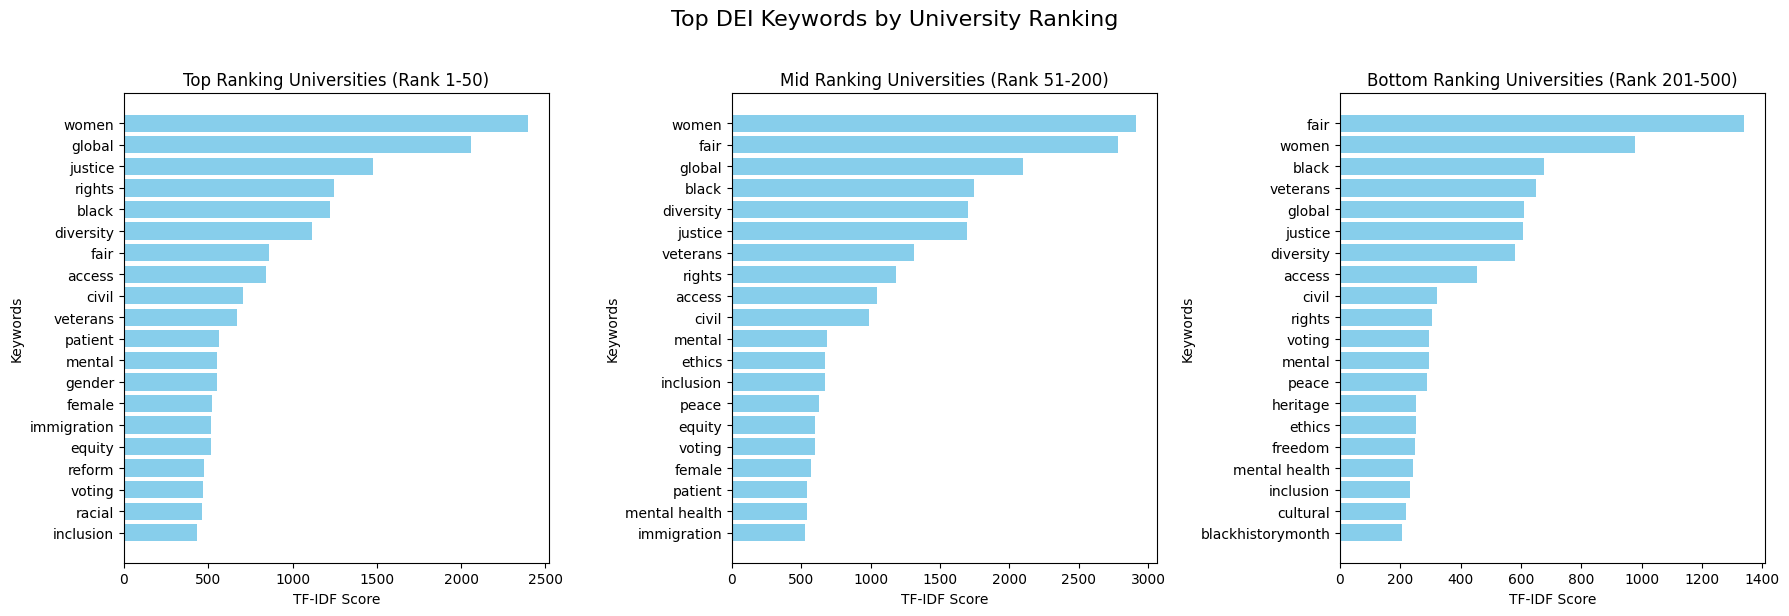

In [16]:
# Assuming `result_df` is the DataFrame from the previous function
plot_keywords_by_ranking_bracket(
    tfidf_df=top_dei_words_ranking_df,
    bracket_col='RankBracket',
    word_col='Word',
    score_col='Score',
    top_n=20,
    save_path='/kaggle/working/top_dei_keywords_by_ranking_brackets.png'
)


### By Year Brackets

In [17]:
def calculate_tfidf_by_year_brackets(
    df: pd.DataFrame,
    tweet_col: str = 'Processed Tweet',
    year_col: str = 'Year',
    brackets: List[Tuple[int, int]] = [(2010, 2015), (2016, 2019), (2020, 2022)],
    top_n: int = 10
) -> pd.DataFrame:
    """
    Calculate TF-IDF scores for tweets grouped into year brackets, treating each tweet as an individual document.
    
    Args:
        df (pd.DataFrame): DataFrame containing tweets and years.
        tweet_col (str): Column name for processed tweets.
        year_col (str): Column name for years.
        brackets (List[Tuple[int, int]]): Year ranges for brackets.
        top_n (int): Number of top words to return per bracket.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['Bracket', 'Word', 'Score'].
    """
    # Define a function to assign year brackets
    def assign_bracket(year):
        for start, end in brackets:
            if start <= year <= end:
                return f"{start}-{end}"
        return None
    
    # Assign year brackets to tweets
    df['YearBracket'] = df[year_col].apply(assign_bracket)
    
    # Drop rows without a valid bracket
    df = df.dropna(subset=['YearBracket'])
    
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 3))
    
    # List to store results
    results = []
    
    # Loop through each bracket
    for bracket, group in df.groupby('YearBracket'):
        # Get processed tweets for the current bracket
        tweets = group[tweet_col]
        
        # Ensure there are non-empty tweets
        tweets = tweets[tweets.str.strip() != '']
        
        if not tweets.empty:
            # Compute TF-IDF scores
            tfidf_matrix = vectorizer.fit_transform(tweets)
            feature_names = vectorizer.get_feature_names_out()
            scores = tfidf_matrix.sum(axis=0).A1  # Sum the TF-IDF scores for each word
            
            # Get top words and their scores
            top_indices = scores.argsort()[-top_n:][::-1]
            for idx in top_indices:
                results.append({
                    'Bracket': bracket,
                    'Word': feature_names[idx],
                    'Score': scores[idx]
                })
    
    return pd.DataFrame(results)


NameError: name 'Tuple' is not defined

In [ ]:
# Calculate TF-IDF top words
top_words_by_bracket = calculate_tfidf_by_year_brackets(
    df=tweets,
    tweet_col='Processed Tweet',
    year_col='Year',
    top_n=1000
)

In [ ]:
# Filter the DataFrame to keep only DEI-related keywords
top_words_by_bracket['Word_lower'] = top_words_by_bracket['Word'].str.lower()
top_dei_words_df = top_words_by_bracket[top_words_by_bracket['Word_lower'].isin([word.lower() for word in dei_keywords])]

def plot_top_dei_keywords(
    top_dei_words_df: pd.DataFrame,
    save_path: str = '/kaggle/working/top_dei_keywords_by_year_brackets.png'
):
    """
    Plot the top DEI keywords for each year bracket and save the plot.

    Args:
        top_dei_words_df (pd.DataFrame): DataFrame containing 'Bracket', 'Word', and 'Score' columns.
        save_path (str): Path to save the plot, starting with '/kaggle/working/'.
    """
    # Get unique brackets
    brackets = top_dei_words_df['Bracket'].unique()
    
    # Create subplots
    fig, axes = plt.subplots(1, len(brackets), figsize=(18, 6), sharey=False)

    # Ensure axes is iterable even for a single plot
    if len(brackets) == 1:
        axes = [axes]

    # Loop through each bracket and plot
    for idx, bracket in enumerate(brackets):
        # Filter data for the current bracket
        bracket_data = top_dei_words_df[top_dei_words_df['Bracket'] == bracket]
        
        # Sort and select top 10 words by score
        top_dei_words = bracket_data.sort_values(by='Score', ascending=False).head(10)
        
        # Plot bar chart
        axes[idx].barh(top_dei_words['Word'], top_dei_words['Score'], color='skyblue')
        axes[idx].set_title(f"Top DEI Keywords: {bracket}", fontsize=10)
        axes[idx].set_xlabel("TF-IDF Score")
        axes[idx].set_ylabel("Keywords")
        axes[idx].invert_yaxis()  # Ensure the highest score appears at the top
    
    # Add an overall title
    fig.suptitle("Top DEI Keywords Across Year Brackets", fontsize=16)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(save_path)
    print(f"Plot saved at: {save_path}")
    
    # Show the plot
    plt.show()

plot_top_dei_keywords(top_dei_words_df)

In [ ]:
print(top_dei_words_df)

## By Account types

In [ ]:
school_categories = ['MainHandle','BusinessSchool', 'MedSchool', 'LawSchool', 'EnggSchool']
school_categories

In [ ]:

def calculate_tfidf_by_categories(
    df: pd.DataFrame,
    tweet_col: str = 'Processed Tweet',
    category_cols: List[str] = None,
    top_n: int = 10
) -> pd.DataFrame:
    """
    Calculate TF-IDF scores for tweets grouped by categories, treating each tweet as an individual document.
    
    Args:
        df (pd.DataFrame): DataFrame containing tweets and category columns.
        tweet_col (str): Column name for processed tweets.
        category_cols (List[str]): List of column names for the school categories.
        top_n (int): Number of top words to return per category.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['Category', 'Word', 'Score'].
    """
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 3))
    
    # List to store results
    results = []
    
    # Loop through each category
    for category in category_cols:
        # Filter tweets for the current category
        category_tweets = df[df[category] == 1][tweet_col]
        
        # Ensure there are non-empty tweets
        category_tweets = category_tweets[category_tweets.str.strip() != '']
        
        if not category_tweets.empty:
            # Compute TF-IDF scores
            tfidf_matrix = vectorizer.fit_transform(category_tweets)
            feature_names = vectorizer.get_feature_names_out()
            scores = tfidf_matrix.sum(axis=0).A1  # Sum the TF-IDF scores for each word
            
            # Get top words and their scores
            top_indices = scores.argsort()[-top_n:][::-1]
            for idx in top_indices:
                results.append({
                    'Category': category,
                    'Word': feature_names[idx],
                    'Score': scores[idx]
                })
    
    return pd.DataFrame(results)


In [ ]:
top_words_by_category = calculate_tfidf_by_categories(
    df=tweets, 
    tweet_col='Processed Tweet', 
    category_cols=school_categories, 
    top_n=1000
)

In [ ]:
print(top_words_by_category )

In [ ]:

top_dei_words_category_df = top_words_by_category[top_words_by_category['Word'].isin([word.lower() for word in dei_keywords])]

In [ ]:
def plot_categorywise_dei_keywords(category_tfidf_df, categories, word_col='Word', score_col='Score', top_n=25, save_path = None):
    """
    Plots top DEI keywords for each category in subplots.
    
    Args:
        category_tfidf_df (pd.DataFrame): DataFrame containing TF-IDF scores by category.
        categories (list): List of categories to plot (e.g., 'LawSchool', 'BusinessSchool').
        word_col (str): Column name containing the words.
        score_col (str): Column name containing the TF-IDF scores.
        top_n (int): Number of top keywords to display.
    """
    # Create a grid of subplots (2 rows, 2 columns for 4 categories)
    rows = (len(categories) + 1) // 2  # Two subplots per row
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for idx, category in enumerate(categories):
        ax = axes[idx]

        # Filter TF-IDF data for the current category
        category_data = category_tfidf_df[category_tfidf_df['Category'] == category]
        top_keywords = category_data.nlargest(top_n, score_col).iloc[::-1] 

        # Plot horizontal bar chart
        ax.barh(top_keywords[word_col], top_keywords[score_col], color='skyblue')
        ax.set_title(f"Top DEI Keywords: {category}", fontsize=14)
        ax.set_xlabel("TF-IDF Score", fontsize=12)
        ax.set_ylabel("Keywords", fontsize=12)

    # Remove any unused subplots
    for idx in range(len(categories), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save the plot with high quality
    print(f"Plot saved to {save_path}")
    plt.show()

In [ ]:
plot_categorywise_dei_keywords(
    category_tfidf_df=top_dei_words_category_df, 
    categories=school_categories, 
    save_path='/kaggle/working/top_dei_keywords_by_account.png'
)


In [ ]:
def plot_categorywise_dei_keywords(
    category_tfidf_df, 
    categories, 
    main_handle='MainHandle', 
    word_col='Word', 
    score_col='Score', 
    top_n=25, 
    save_path=None
):
    """
    Plots top DEI keywords for the `MainHandle` category in a larger plot and other categories in a grid.
    
    Args:
        category_tfidf_df (pd.DataFrame): DataFrame containing TF-IDF scores by category.
        categories (list): List of categories to plot (e.g., 'LawSchool', 'BusinessSchool').
        main_handle (str): Name of the `MainHandle` category to plot separately.
        word_col (str): Column name containing the words.
        score_col (str): Column name containing the TF-IDF scores.
        top_n (int): Number of top keywords to display.
        save_path (str): Path to save the plot image. If None, the plot is not saved.
    """
    import matplotlib.pyplot as plt

    # Separate the `MainHandle` category from the rest
    other_categories = [cat for cat in categories if cat != main_handle]
    
    # Create the figure and axes for `MainHandle`
    fig, main_ax = plt.subplots(figsize=(14, 8))  # Larger figure for `MainHandle`
    main_data = category_tfidf_df[category_tfidf_df['Category'] == main_handle]
    main_top_keywords = main_data.nlargest(top_n, score_col)  # Keep in descending order
    main_ax.barh(main_top_keywords[word_col], main_top_keywords[score_col], color='skyblue')
    main_ax.set_title(f"Top {top_n} DEI Keywords: {main_handle}", fontsize=18)
    main_ax.set_xlabel("TF-IDF Score", fontsize=14)
    main_ax.set_ylabel("Keywords", fontsize=14)
    main_ax.invert_yaxis()  # Ensure the highest score is at the top
    plt.tight_layout()
    
    # Save or show the `MainHandle` plot
    if save_path:
        plt.savefig(f"{save_path}_MainHandle.png", dpi=300, bbox_inches='tight')
        print(f"MainHandle plot saved to {save_path}_MainHandle.png")
    plt.show()

    # Create a grid of subplots for other categories
    rows = (len(other_categories) + 1) // 2  # Two subplots per row
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for idx, category in enumerate(other_categories):
        ax = axes[idx]

        # Filter TF-IDF data for the current category
        category_data = category_tfidf_df[category_tfidf_df['Category'] == category]
        top_keywords = category_data.nlargest(top_n, score_col)  # Keep in descending order

        # Plot horizontal bar chart
        ax.barh(top_keywords[word_col], top_keywords[score_col], color='skyblue')
        ax.set_title(f"Top {top_n} DEI Keywords: {category}", fontsize=14)
        ax.set_xlabel("TF-IDF Score", fontsize=12)
        ax.set_ylabel("Keywords", fontsize=12)
        ax.invert_yaxis()  # Ensure the highest score is at the top

    # Remove any unused subplots
    for idx in range(len(other_categories), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_OtherCategories.png", dpi=300, bbox_inches='tight')  # Save the plot with high quality
        print(f"Other categories plot saved to {save_path}_OtherCategories.png")
    plt.show()



In [ ]:
plot_categorywise_dei_keywords(
    category_tfidf_df=top_dei_words_category_df, 
    categories=['LawSchool', 'BusinessSchool', 'MedicalSchool', 'EngineeringSchool'], 
    save_path='/kaggle/working/top_dei_keywords_by_category.png'
)


## Functions for EDA

### University Categories

In [ ]:
def find_category(tweets, school_categories):
    uni_count_by_category = pd.Series()
    uni_by_category = {}
    for category in school_categories:
        universities = tweets[tweets[category] == 1]['University'].unique()
        uni_count_by_category[category] = len(universities)
        uni_by_category[category] = universities
    return uni_count_by_category, uni_by_category
        

In [ ]:
uni_count_by_category, uni_by_category = find_category(tweets, school_categories)
uni_count_by_category_business, uni_by_category_business = find_category(tweets_business, school_categories)
uni_count_by_category_law, uni_by_category_law = find_category(tweets_law, school_categories)

### Check Common Universities in Categories

In [ ]:
categories_with_unis = []
for key in uni_by_category.keys():
    if len(uni_by_category[key]):
        categories_with_unis.append(key)
print(categories_with_unis)

In [ ]:
def check_common(uni_by_category):
    
    categories_with_unis = []
    
    for key in uni_by_category.keys():
        if len(uni_by_category[key]):
            categories_with_unis.append(key)
    
    print("Categories: ",categories_with_unis,"\n")
    
    n = len(categories_with_unis)
    
    for i in range(n-1):
        for j in range(i+1, n):
            list1 = uni_by_category[categories_with_unis[i]]
            list2 = uni_by_category[categories_with_unis[j]]

            common = set(list1).intersection(list2)
            if common:
                print(categories_with_unis[i], "and", categories_with_unis[j], "has common universities.")
            else:
                print(categories_with_unis[i], "and", categories_with_unis[j], "has no common universities.")
        


print("For main directory")
check_common(uni_by_category)
print('\n')
print("For business directory")
check_common(uni_by_category_business)  
print('\n')
print("For law directory")
check_common(uni_by_category_law)  

## Universities in Categories

In [ ]:
def plot_uni_by_categories(data, plot_title):
    plt.figure(figsize = (10, 6))
    plt.bar(data.index, data.values)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Number of Universities', fontsize=12)
    plt.title(f"{plot_title} by Category", fontsize = 15, weight = 600)
    plt.tight_layout()
    plt.show()
    

In [9]:
university_names = list(tweets['University'].unique())

## Histogram of Tweets

### Tweets from Output - Main

In [ ]:
tweets.shape

In [ ]:
tweets['Date'] = pd.to_datetime(tweets['Date'], errors = 'coerce')
tweets['Year'] = tweets['Date'].dt.year

In [ ]:
tweets_by_year = tweets['Year'].value_counts()
tweets_by_year.index

In [ ]:
plt.figure(figsize = (10, 6))
plt.bar(tweets_by_year.index, tweets_by_year.values)
plt.xlabel('Year', fontsize = 12)
plt.xticks(ticks = tweets_by_year.index, labels = tweets_by_year.index)
plt.ylabel('Tweet Count', fontsize = 12)
plt.title('Histogram of Tweets Over Time', fontsize = 15, weight = 500)
plt.tight_layout()
plt.show()

In [ ]:
# Create histogram
plt.figure(figsize = (12, 6))
counts, bins, patches = plt.hist(
    tweets['Year'], 
    bins=np.arange(2009.5, 2023.5, 1), 
    align='mid', 
    rwidth=0.8, 
)

# Add tweet counts on top of each bar
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(
        bin_edge + 0.5,  # Center of the bar
        count + 5,       # Slightly above the bar
        str(int(count)), # Display the count
        ha='center',     # Horizontal alignment
        va='bottom',     # Vertical alignment
        fontsize=10
    )

# Add labels and title
plt.title('Histogram of All Tweets Over the Years', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(range(2010, 2023))
plt.tight_layout()

# Show plot
plt.show()

## Find HBCUs

In [10]:
hbcu_list = [
    "Alabama A&M University",
    "Alabama State University",
    "Albany State University",
    "Alcorn State University",
    "Allen University",
    "American Baptist College",
    "University of Arkansas at Pine Bluff",
    "Arkansas Baptist College",
    "Barber-Scotia College",
    "Benedict College",
    "Bennett College",
    "Bethune-Cookman University",
    "Bishop State Community College",
    "Bluefield State College",
    "Bowie State University",
    "Carver College",
    "Central State University",
    "Cheyney University of Pennsylvania",
    "Claflin University",
    "Clark Atlanta University",
    "Clinton College",
    "Coahoma Community College",
    "Concordia College, Alabama (closed 2018)",
    "Coppin State University",
    "Delaware State University",
    "Denmark Technical College",
    "Dillard University",
    "University of the District of Columbia",
    "Edward Waters University",
    "Elizabeth City State University",
    "Fayetteville State University",
    "Fisk University",
    "Florida A&M University",
    "Florida Memorial University",
    "Fort Valley State University",
    "Gadsden State Community College (Valley Street campus)",
    "Grambling State University",
    "Hampton University",
    "Harris-Stowe State University",
    "Hinds Community College at Utica",
    "Hood Theological Seminary",
    "Howard University",
    "Huston-Tillotson University",
    "Interdenominational Theological Center",
    "J. F. Drake State Technical College",
    "Jackson State University",
    "Jarvis Christian University",
    "Johnson C. Smith University",
    "Johnson C Smith Theological Seminary",
    "Kentucky State University",
    "Knoxville College",
    "Lane College",
    "Langston University",
    "Lawson State Community College",
    "LeMoyne-Owen College",
    "Lewis College of Business (closed 2013)",
    "The Lincoln University",
    "Lincoln University",
    "Livingstone College",
    "University of Maryland Eastern Shore",
    "Meharry Medical College",
    "Miles College",
    "Miles School of Law",
    "Mississippi Valley State University",
    "Morehouse College",
    "Morehouse School of Medicine",
    "Morgan State University",
    "Morris Brown College",
    "Morris College",
    "Norfolk State University",
    "North Carolina Agricultural and Technical State University",
    "North Carolina Central University",
    "Oakwood University",
    "Paine College",
    "Paul Quinn College",
    "Payne Theological Seminary",
    "Philander Smith College",
    "Prairie View A&M University",
    "Rust College",
    "Saint Paul's College (closed 2013)",
    "Savannah State University",
    "Selma University",
    "Shaw University",
    "Shelton State Community College - C A Fredd Campus",
    "Shorter College",
    "Simmons College of Kentucky",
    "South Carolina State University",
    "Southern University at New Orleans",
    "Southern University at Shreveport",
    "Southern University and A&M College",
    "Southwestern Christian College",
    "Spelman College",
    "St. Augustine's University",
    "St. Philip's College",
    "Stillman College",
    "Talladega College",
    "Tennessee State University",
    "Texas College",
    "Texas Southern University",
    "Tougaloo College",
    "H. Councill Trenholm State Community College",
    "Tuskegee University",
    "University of the Virgin Islands",
    "Virginia State University",
    "Virginia Union University",
    "Virginia University of Lynchburg",
    "Voorhees University",
    "West Virginia State University",
    "Wilberforce University",
    "Wiley University",
    "Winston-Salem State University",
    "Xavier University of Louisiana"
]

In [11]:
hbcus = [name for name in hbcu_list if name in university_names ]
print("There are",len(hbcus), "HBCUs:")
for hbcu in hbcus:
    print(hbcu)

There are 10 HBCUs:
Fisk University
Florida A&M University
Hampton University
Howard University
Morehouse College
Morgan State University
North Carolina Agricultural and Technical State University
Spelman College
Tougaloo College
Winston-Salem State University
